# Bank Project - Resampling

In [302]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
import preprocessing as prep
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV


from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

## Fetch Data

In [303]:
df = pd.read_csv('./data/bank-full.csv', sep=';')

In [304]:
ct = ColumnTransformer(
    [("target",prep.TargetTransformer(),'y')])

y_trans = pd.DataFrame(data = ct.fit_transform(df),columns=['y_trans'] ,index = df.index)

In [305]:
df_t = pd.concat([y_trans,df],axis=1).drop(['y'],axis=1)

In [306]:
# Upsample minority classPython

# Separate majority and minority classes
df_majority = df_t[df_t.y_trans==0]
df_minority = df_t[df_t.y_trans==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=2) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [307]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=len(df_minority),    # to match majority class
                                 random_state=101) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

In [309]:
cat_features = ['job','marital','education','default','housing','loan','contact','poutcome','month']

ct = ColumnTransformer(
    [
    ("logplus1",prep.LogPlus1Transformer(),['duration','age']),
    ("campaign",prep.CampaignTransformer(),'campaign'),
    ("balance",prep.CampaignTransformer(),'balance'),
    ('ohe',OneHotEncoder(sparse=False),cat_features)
    ]
    )

In [401]:
X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop(['y_trans'],axis=1), df_downsampled.y_trans, stratify = df_downsampled.y_trans)

In [408]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
rtree = RandomForestClassifier(class_weight='balanced')
rtree.fit(ct.fit_transform(X_train),y_train)
dtree = DecisionTreeClassifier(class_weight='balanced')
dtree.fit(ct.fit_transform(X_train),y_train)
from sklearn.linear_model import LogisticRegressionCV
lreg = LogisticRegression( penalty='l2', solver='saga', C=1)
lreg.fit(ct.fit_transform(X_train),y_train)
from sklearn.naive_bayes import GaussianNB
nbayes = GaussianNB()
nbayes.fit(ct.fit_transform(X_train),y_train)

C:\Users\casey\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

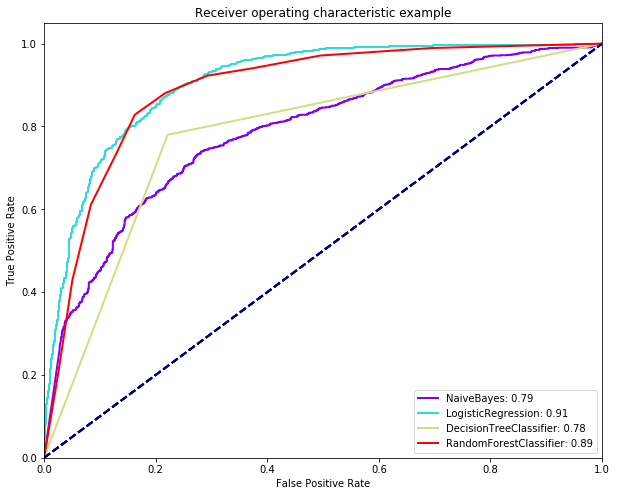

In [409]:
plt.figure(figsize=(10,8))
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,4)))
model_dict = {'NaiveBayes':nbayes,'LogisticRegression':lreg,'DecisionTreeClassifier':dtree,'RandomForestClassifier':rtree}

for model in model_dict.keys():
    y_score = model_dict[model].predict_proba(ct.fit_transform(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    lw = 2
    c = next(color)
    plt.plot(fpr, tpr, lw=lw, color = c, label=model + ': %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [416]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score)

In [425]:
rtree_params = {'n_estimators':[2,5,10,20,50],'max_depth':[5,10,20,100],
 'min_samples_split':[2,10,20],
  'min_samples_leaf':[2,4,10,20]}
clf = GridSearchCV(rtree, cv=3, param_grid = rtree_params)
clf.fit(ct.fit_transform(X_train), y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [2, 5, 10, 20, 50], 'max_depth': [5, 10, 20, 100], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [2, 4, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [426]:
precision_score(y_test, clf.predict(ct.transform(X_test)))

0.8147892190739461